In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
## Load the data set
df = pd.read_pickle('sampled_data_bands_m2.pkl')





df.band.replace('Metallica',0,inplace=True)
df.band.replace('Rush',1,inplace=True)
df.reindex()

X = df.drop(['band','track_names','index'],axis=1)
y = df['band']

# X['bpm'] = pd.to_numeric(X['bpm'], errors='coerce').fillna(0)
# X['harmonic_rythmic_ratio'] = pd.to_numeric(X['harmonic_rythmic_ratio'], errors='coerce').fillna(0)
# X['spectral_centroid'] = pd.to_numeric(X['spectral_centroid'], errors='coerce').fillna(0)
# X['spectral_flatness'] = pd.to_numeric(X['spectral_flatness'], errors='coerce').fillna(0)
# X['count_delta_above_mean'] = pd.to_numeric(X['count_delta_above_mean'], errors='coerce').fillna(0)
# X['ratio_above_rmse_mean'] = pd.to_numeric(X['harmonic_rythmic_ratio'], errors='coerce').fillna(0)
# X['max_rmse'] = pd.to_numeric(X['spectral_centroid'], errors='coerce').fillna(0)
# X['mean_rms'] = pd.to_numeric(X['spectral_flatness'], errors='coerce').fillna(0)



#np.isnan(y.any()) #and gets False
#and gets True
#X = X.as_matrix().astype(np.float)
#y = y.as_matrix().astype(np.float)

In [2]:
%%time
### try knn, then write a function to explore the rest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(X_train)
X_test_scaled  = ssX.transform(X_test)

CPU times: user 101 ms, sys: 27 ms, total: 128 ms
Wall time: 47.9 ms


In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train_scaled)
pcafeatures_train = pca.transform(X_train_scaled)
pcafeatures_test = pca.transform(X_test)

In [28]:
#### KNN Model

In [30]:
%%time
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(pcafeatures_train, y_train)
y_pred = knn.predict(pcafeatures_train)
print(knn.score(pcafeatures_test,y_test)) 

0.5770532143955706
CPU times: user 79 ms, sys: 5.44 ms, total: 84.4 ms
Wall time: 38.1 ms


In [31]:
%%time
####
k_range = list(range(1, 10))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)
# instantiate and fit the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(pcafeatures_train, y_train)
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.7284113381674358
{'n_neighbors': 9, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')
CPU times: user 15.8 s, sys: 519 ms, total: 16.3 s
Wall time: 5.1 s


In [32]:
prediction_hard = grid.predict(pcafeatures_test)
actual = y_test
accuracy_score(y_test,prediction_hard)

0.43801907105506

In [33]:
grid.score(pcafeatures_test, y_test)

0.43801907105506

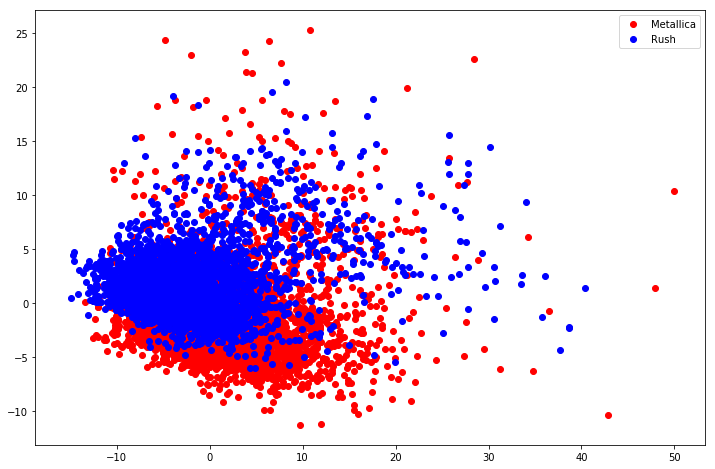

In [34]:
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','b','g','c','m','y','orange','k','aqua','yellow'])
    target_ids = range(len(target_names))
    plt.figure()
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label)
    plt.legend()

    
plot_PCA_2D(pcafeatures_train, target=y_train.astype(int), target_names=['Metallica', 'Rush'])
plt.gcf().set_size_inches(12,8)
    

In [25]:
from sklearn.manifold import TSNE

Xsne = TSNE(n_components=2,perplexity=100.0).fit_transform(X_train_scaled[:1000,:])


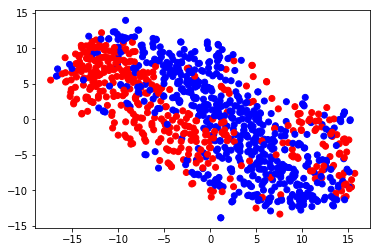

In [26]:
plt.scatter(Xsne[:,0],Xsne[:,1],c=['r' if band==1 else 'b' for band in y_train])

In [15]:
#import seaborn as sns; sns.set(font_scale=1.2)
#sns.pairplot(df, hue='band')

In [16]:
### Try a bunch of models

In [4]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#svc = SVC(probability=True)
models = [('knn', KNN), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier),
          ('svm', SVC)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 12),
        'weights': ['uniform', 'distance']
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
       'n_estimators': [50, 100, 200],
       'max_depth': [1,2,3,4,5],
       'min_samples_leaf': [3,6,10]
    },
    {
        'C': [50,100], 
        'kernel': ['rbf'] ,
        'probability': [True]
    },
 
]
    
    


grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params,cv=10, scoring='accuracy')
    grid.fit(pcafeatures_train, y_train)
    s = f"{name}: best score: {grid.best_score_}"
    print(s)
    grids[name] = grid

knn: best score: 0.7330257086354647
logistic: best score: 0.7410678971654582
tree: best score: 0.7421226104152934
forest: best score: 0.7485827290705339


In [28]:
# Let's get the testing score
grids['svm'].best_estimator_.score(pcafeatures_test, y_test)

0.824669332513073

In [29]:
grids['svm'].best_estimator_

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
#import seaborn as sns; sns.set(font_scale=1.2)
#sns.pairplot(df.drop('index',axis=1), hue='band')

In [31]:
prediction_hard = grids['svm'].best_estimator_.predict(pcafeatures_test)
actual = y_test
accuracy_score(y_test,prediction_hard)

0.824669332513073

In [5]:
%%time
## Tune the hyper parameters of svm if possible and refit!

models = [('svm',SVC)]

gamma_range = np.logspace(-2, 0, 5)
C_range = np.logspace(1.75,2.5,5)

param_choices = [

   {
       'C': C_range, 
       'kernel': ['rbf'],
       'gamma': gamma_range
   },
 
]
grids = {}
for model_info, params in zip(models, param_choices):
   name, model = model_info
   print(name,model)
   grid = GridSearchCV(model(), params)
   grid.fit(X_train_scaled, y_train)
   s = f"{name}: best score: {grid.best_score_}"
   print(s)
   grids[name] = grid

svm <class 'sklearn.svm.classes.SVC'>
svm: best score: 0.970995385629532
CPU times: user 6min 2s, sys: 1.38 s, total: 6min 4s
Wall time: 6min 4s


In [33]:
## find which features separate the most...?? of the ones that mis-classify, 
## what is having the most trouble
### do other approach... then get two proba
#### logisitic regression with the proba

In [34]:
## EXPORT MODEL 1
from sklearn.pipeline import Pipeline
import pickle

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('svm', SVC(**grids['svm'].best_params_))])
pipeline.fit(X_train,y_train)
pickle.dump(pipeline, open('model2.pkl', 'wb'))

test_data = [pcafeatures_test,y_test]
pickle.dump(test_data,open('test_data2.pkl','wb'))

In [35]:
train_data = [pcafeatures_train,y_train]
pickle.dump(train_data,open('training_data2.pkl','wb'))